
Running Regression Models

********** LASSO REGRESSION **********

=== Train Set Evaluation ===
MAE: 1.4890
MSE: 3.2025
R²: 0.6942

=== Test Set Evaluation ===
MAE: 1.3161
MSE: 2.6412
R²: 0.4265

********** RIDGE REGRESSION **********

=== Train Set Evaluation ===
MAE: 1.0658
MSE: 1.8285
R²: 0.8254

=== Test Set Evaluation ===
MAE: 1.3912
MSE: 2.9054
R²: 0.3691

Running Probabilistic Neural Network for Seed 25
Epoch 1: Train MSE = 9.9111, Test MSE = 6.0022
Epoch 100: Train MSE = 0.8736, Test MSE = 1.4253
Epoch 200: Train MSE = 0.8407, Test MSE = 1.5263
Epoch 300: Train MSE = 0.8042, Test MSE = 1.6946
Epoch 400: Train MSE = 0.7970, Test MSE = 1.6467
Epoch 500: Train MSE = 0.8092, Test MSE = 1.6747
Epoch 600: Train MSE = 0.7950, Test MSE = 1.8702
Epoch 700: Train MSE = 0.7953, Test MSE = 1.8884
Epoch 800: Train MSE = 0.7975, Test MSE = 1.8541
Epoch 900: Train MSE = 0.8172, Test MSE = 1.8506
Epoch 1000: Train MSE = 0.8144, Test MSE = 1.7923
Epoch 1100: Train MSE = 0.7929, Test MSE = 1.85

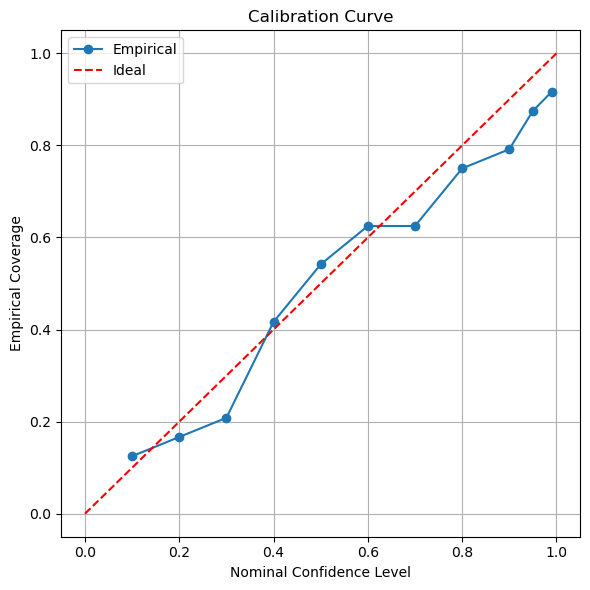

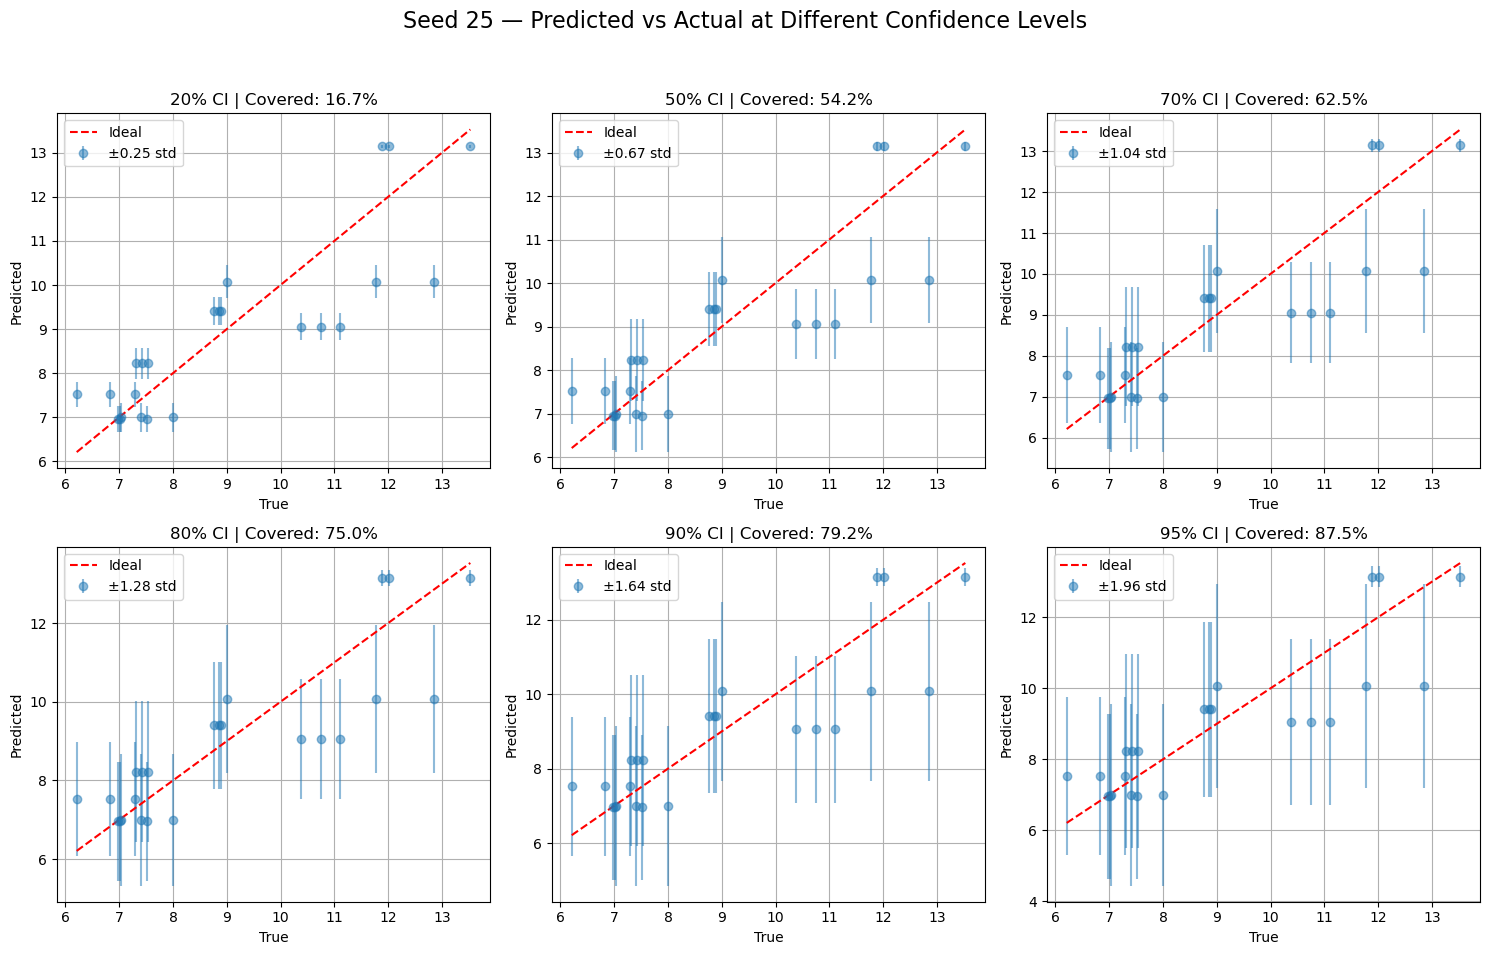

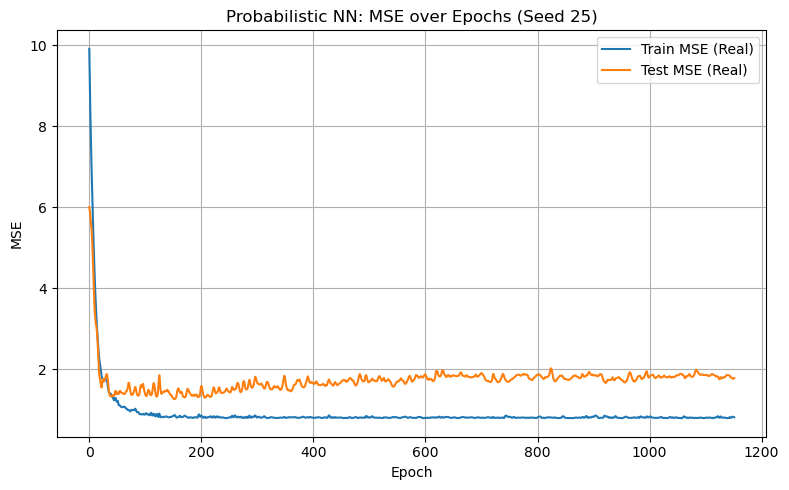

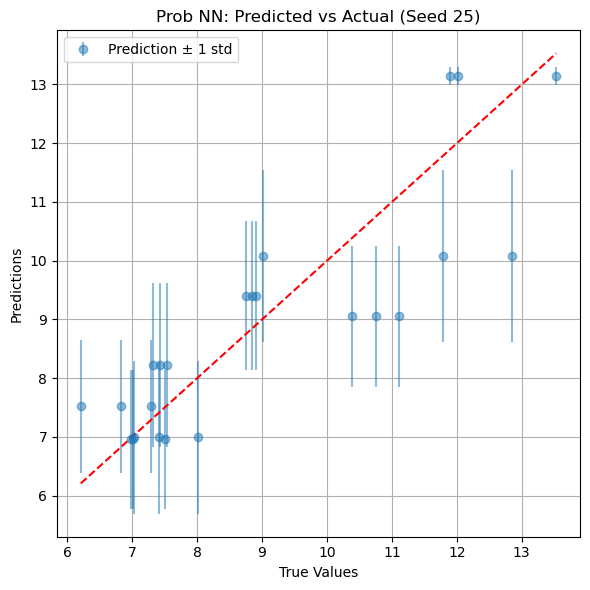


Best Seed: 25 with MAE = 0.9102


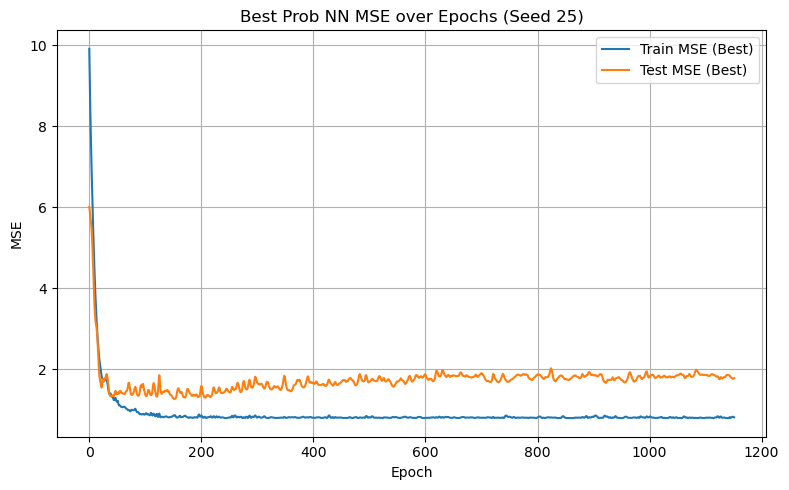

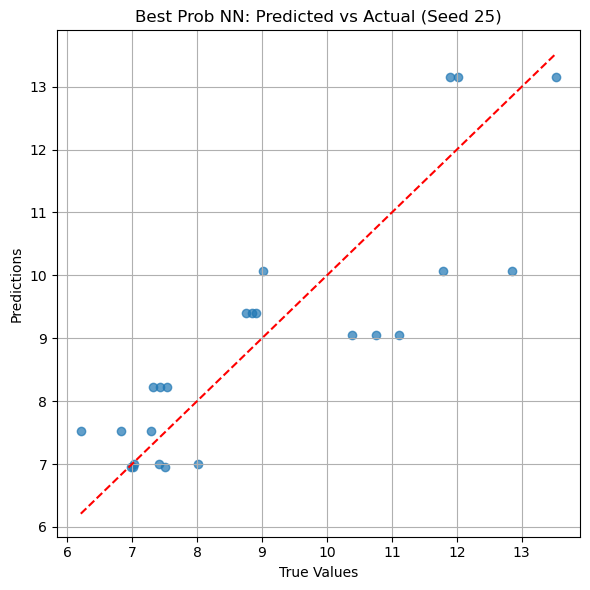

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import copy
import random
import scipy.stats

relevant_columns = ['a', 'b', 'c', 'd']


def gaussian_crps(mu, sigma, y_true):
    """
    Computes CRPS for a Gaussian distribution.
    All tensors must be 1D and same length.
    """
    z = (y_true - mu) / sigma
    cdf = 0.5 * (1 + torch.erf(z / math.sqrt(2)))
    pdf = torch.exp(-0.5 * z ** 2) / math.sqrt(2 * math.pi)

    crps = sigma * (z * (2 * cdf - 1) + 2 * pdf - 1 / math.sqrt(math.pi))
    return torch.mean(crps)


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



def compute_calibration_error(coverages_dict):
    abs_errors = []
    sq_errors = []

    for nominal, empirical in coverages_dict.items():
        abs_errors.append(abs(nominal - empirical))
        sq_errors.append((nominal - empirical) ** 2)

    mean_abs_calib_error = np.mean(abs_errors)
    msce = np.mean(sq_errors)

    return mean_abs_calib_error, msce


def compute_sharpness(std_pred, level=0.9):
    z = scipy.stats.norm.ppf(0.5 + level / 2.0)
    avg_width = 2 * z * np.mean(std_pred)
    return avg_width


def compute_nll(y_true_std, mean_pred, logvar_pred):
    precision = torch.exp(-logvar_pred)
    nll = 0.5 * (logvar_pred + (y_true_std - mean_pred) ** 2 * precision)
    return nll.mean().item()



def calibration_penalty(y_true, y_pred_mean, y_pred_std, levels=[0.5, 0.8, 0.95], k=50):
    penalty = 0.0
    for level in levels:
        z = scipy.stats.norm.ppf(0.5 + level / 2)
        lower = y_pred_mean - z * y_pred_std
        upper = y_pred_mean + z * y_pred_std

        inside_lower = torch.sigmoid(k * (y_true - lower))
        inside_upper = torch.sigmoid(k * (upper - y_true))
        smooth_coverage = inside_lower * inside_upper

        empirical_coverage = smooth_coverage.mean()
        penalty += (empirical_coverage - level) ** 2

    return penalty / len(levels)



# === Helper: Evaluate metrics ===
def evaluate(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {label} Set Evaluation ===")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    return mae, mse, r2



def compute_and_plot_coverage(
    y_true, 
    y_pred, 
    std_pred, 
    levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9, 0.95, 0.99], 
    plot=True, 
    verbose=True
):
    import matplotlib.pyplot as plt
    import scipy.stats

    coverages = {}
    for level in levels:
        z = scipy.stats.norm.ppf(0.5 + level / 2.0)
        lower = y_pred - z * std_pred
        upper = y_pred + z * std_pred
        coverage = np.mean((y_true >= lower) & (y_true <= upper))
        coverages[round(level, 4)] = coverage

        if verbose:
            print(f"Expected {int(level*100)}% CI → Empirical coverage: {coverage*100:.2f}%")

    if plot:
        plt.figure(figsize=(6, 6))
        plt.plot(list(coverages.keys()), list(coverages.values()), label='Empirical', marker='o')
        plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
        plt.xlabel("Nominal Confidence Level")
        plt.ylabel("Empirical Coverage")
        plt.title("Calibration Curve")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return coverages


def plot_seed_coverage_grid(y_true, y_pred, std_pred, coverages_dict, seed, levels=[0.5, 0.8, 0.9, 0.95, 0.99]):
    import math

    num_levels = len(levels)
    cols = 3
    rows = math.ceil(num_levels / cols)

    plt.figure(figsize=(cols * 5, rows * 5))

    for i, level in enumerate(levels):
        z = scipy.stats.norm.ppf(0.5 + level / 2.0)
        lower = y_pred - z * std_pred
        upper = y_pred + z * std_pred

        plt.subplot(rows, cols, i + 1)
        plt.errorbar(
            y_true,
            y_pred,
            yerr=z * std_pred,
            fmt='o',
            alpha=0.5,
            label=f'±{z:.2f} std'
        )
        plt.plot(
            [y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            'r--',
            label='Ideal'
        )
        plt.xlabel("True")
        plt.ylabel("Predicted")
        
        # Use .get() to avoid KeyError due to float precision
        empirical = coverages_dict.get(round(level, 4), None)
        if empirical is not None:
            title = f"{int(level*100)}% CI | Covered: {empirical*100:.1f}%"
        else:
            title = f"{int(level*100)}% CI | Covered: N/A"
        plt.title(title)

        plt.grid(True)
        plt.legend()

    plt.suptitle(f"Seed {seed} — Predicted vs Actual at Different Confidence Levels", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



# === Load data ===
df = pd.read_excel('data.xlsx')  # expects columns: a, b, c, d, 1, 2, 3

# === Split BEFORE melting ===
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# === Melt (long format) ===
train_long = pd.melt(df_train, id_vars=relevant_columns, value_vars=[1, 2, 3],
                     var_name='trial', value_name='result')
test_long = pd.melt(df_test, id_vars=relevant_columns, value_vars=[1, 2, 3],
                    var_name='trial', value_name='result')

# === Extract inputs and targets ===
X_train_raw = train_long[relevant_columns].values
y_train_raw = train_long['result'].values
X_test_raw = test_long[relevant_columns].values
y_test_raw = test_long['result'].values

# === Polynomial features (for regression models) ===
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_raw)
X_test_poly = poly.transform(X_test_raw)

# === Normalize features ===
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_poly)
X_test_scaled = scaler_X.transform(X_test_poly)

# === Normalize target y ===
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test_raw.reshape(-1, 1)).ravel()

# ========== REGRESSION MODELS ==========
print('\n' + '=' * 30)
print("Running Regression Models")
print('=' * 30)

# === Lasso Regression ===
print('\n' + '*' * 10 + ' LASSO REGRESSION ' + '*' * 10)
lasso = Lasso(alpha=0.006, max_iter=10000)
lasso.fit(X_train_scaled, y_train_scaled)
y_train_pred = scaler_y.inverse_transform(lasso.predict(X_train_scaled).reshape(-1, 1)).ravel()
y_test_pred = scaler_y.inverse_transform(lasso.predict(X_test_scaled).reshape(-1, 1)).ravel()
evaluate(y_train_raw, y_train_pred, label="Train")
evaluate(y_test_raw, y_test_pred, label="Test")

# === Ridge Regression ===
print('\n' + '*' * 10 + ' RIDGE REGRESSION ' + '*' * 10)
ridge = Ridge(alpha=0.01, max_iter=10000)
ridge.fit(X_train_scaled, y_train_scaled)
y_train_pred = scaler_y.inverse_transform(ridge.predict(X_train_scaled).reshape(-1, 1)).ravel()
y_test_pred = scaler_y.inverse_transform(ridge.predict(X_test_scaled).reshape(-1, 1)).ravel()
evaluate(y_train_raw, y_train_pred, label="Train")
evaluate(y_test_raw, y_test_pred, label="Test")

# === Probabilistic Neural Network (PyTorch) ===

class ProbabilisticNet(nn.Module):
    def __init__(self, input_dim):
        super(ProbabilisticNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(128, 320),
            nn.ReLU(),
            nn.Dropout(p=0.1)
        )
        self.mean_head = nn.Linear(320, 1)
        self.logvar_head = nn.Linear(320, 1)

    def forward(self, x):
        hidden = self.net(x)
        mean = self.mean_head(hidden)
        logvar = self.logvar_head(hidden)
        return mean, logvar

def gaussian_nll_loss(y_pred_mean, y_pred_logvar, y_true):
    # Negative log-likelihood for Gaussian
    precision = torch.exp(-y_pred_logvar)
    return torch.mean(0.5 * (y_pred_logvar + (y_true - y_pred_mean) ** 2 * precision))


class EarlyStopping:
    def __init__(self, patience=1000, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.best_epoch = 0
        self.counter = 0
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, current_loss, model, epoch):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.best_epoch = epoch
            self.counter = 0
            self.best_model_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


# === Train probabilistic model ===

best_mae = float('inf')
best_seed = None
best_model_state = None
best_train_mse_curve = []
best_test_mse_curve = []
best_y_test_true = None
best_y_test_pred = None

seeds_to_try = [25]# [1, 45, 15, 25]

for seed in seeds_to_try:
    print('\n' + '=' * 30)
    print(f"Running Probabilistic Neural Network for Seed {seed}")
    print('=' * 30)

    set_seed(seed)

    # Prepare data
    X_train_nn = torch.tensor(scaler_X.fit_transform(X_train_raw), dtype=torch.float32)
    X_test_nn = torch.tensor(scaler_X.transform(X_test_raw), dtype=torch.float32)
    y_train_nn = torch.tensor(scaler_y.fit_transform(y_train_raw.reshape(-1, 1)), dtype=torch.float32)
    y_test_nn = torch.tensor(scaler_y.transform(y_test_raw.reshape(-1, 1)), dtype=torch.float32)

    net = ProbabilisticNet(X_train_nn.shape[1])
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    early_stopping = EarlyStopping()

    train_real_mse = []
    test_real_mse = []
    epochs = 5000

    for epoch in range(1, epochs + 1):
        net.train()
        optimizer.zero_grad()
        mean_pred, logvar_pred = net(X_train_nn)
        std_pred = torch.exp(0.5 * logvar_pred)

        #loss = gaussian_nll_loss(mean_pred, logvar_pred, y_train_nn)

        # Anneal k: increase sharpness over epochs to reduce vanishing gradients early
        k = min(50, 5 + epoch // 100)  # gradually increases from 5 to 50 over ~5000 epochs

        nll = gaussian_nll_loss(mean_pred, logvar_pred, y_train_nn)
        calib_pen = calibration_penalty(y_train_nn, mean_pred, std_pred, levels=[0.2,0.3,0.4,0.5, 0.7,0.8, 0.95], k=k)

        weight_nll = 1.0  # NLL weight
        weight_cal = 1.0   # Calibration penalty weight (tune as needed)
        weight_sharp = 1.0
    
        #loss = weight_nll * nll + weight_cal * calib_pen + weight_sharp * torch.mean(std_pred)

        loss = weight_nll * nll + gaussian_crps(mean_pred.squeeze(), std_pred.squeeze(), y_train_nn.squeeze())
        
        loss.backward()
        optimizer.step()

        net.eval()
        with torch.no_grad():
            # Train MSE (for logging)
            mean_train_pred, _ = net(X_train_nn)
            y_train_pred_real = scaler_y.inverse_transform(mean_train_pred.numpy())
            y_train_true_real = scaler_y.inverse_transform(y_train_nn.numpy())
            mse_train = mean_squared_error(y_train_true_real, y_train_pred_real)

            # Test MSE
            mean_test_pred, _ = net(X_test_nn)
            y_test_pred_real = scaler_y.inverse_transform(mean_test_pred.numpy())
            y_test_true_real = scaler_y.inverse_transform(y_test_nn.numpy())
            mse_test = mean_squared_error(y_test_true_real, y_test_pred_real)

        train_real_mse.append(mse_train)
        test_real_mse.append(mse_test)

        if epoch % 100 == 0 or epoch == 1:
            print(f"Epoch {epoch}: Train MSE = {mse_train:.4f}, Test MSE = {mse_test:.4f}")

        early_stopping(mse_test, net, epoch)
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break

    if early_stopping.best_model_state:
        net.load_state_dict(early_stopping.best_model_state)
        print(f"Restored best model from epoch {early_stopping.best_epoch}")

    # Final evaluation
    net.eval()
    with torch.no_grad():
        mean_train_pred, logvar_train_pred = net(X_train_nn)
        y_train_pred_final = scaler_y.inverse_transform(mean_train_pred.numpy())
        y_train_true_final = scaler_y.inverse_transform(y_train_nn.numpy())
        evaluate(y_train_true_final, y_train_pred_final, label=f"Prob NN Train (Seed {seed})")

        # === Train Calibration Metrics ===
        std_train_pred = (torch.exp(0.5 * logvar_train_pred) * scaler_y.scale_[0]).numpy()
        y_train_pred_np = scaler_y.inverse_transform(mean_train_pred.numpy())
        y_train_true_np = scaler_y.inverse_transform(y_train_nn.numpy())
        
        train_coverages = compute_and_plot_coverage(
            y_train_true_np, y_train_pred_np, std_train_pred, plot=False, verbose=False
        )
        train_calib_error, train_msce = compute_calibration_error(train_coverages)
        train_sharpness = compute_sharpness(std_train_pred)
        train_nll = compute_nll(y_train_nn, mean_train_pred, logvar_train_pred)
        
        #print("\n--- Train Set Uncertainty Metrics ---")
        print(f"Calibration Error: {train_calib_error:.4f}")
        print(f"MSCE: {train_msce:.4f}")
        print(f"Sharpness (90% CI): {train_sharpness:.4f}")
        print(f"NLL: {train_nll:.4f}")

        
        mean_test_pred, logvar_test_pred = net(X_test_nn)
        y_test_pred_final = scaler_y.inverse_transform(mean_test_pred.numpy())
        y_test_true_final = scaler_y.inverse_transform(y_test_nn.numpy())
        mae, _, _ = evaluate(y_test_true_final, y_test_pred_final, label=f"Prob NN Test (Seed {seed})")

        # === Test Calibration Metrics ===
        std_test_pred = (torch.exp(0.5 * logvar_test_pred) * scaler_y.scale_[0]).numpy()
        y_test_pred_np = scaler_y.inverse_transform(mean_test_pred.numpy())
        y_test_true_np = scaler_y.inverse_transform(y_test_nn.numpy())
        
        test_coverages = compute_and_plot_coverage(
            y_test_true_np, y_test_pred_np, std_test_pred, plot=False, verbose=False
        )
        test_calib_error, test_msce = compute_calibration_error(test_coverages)
        test_sharpness = compute_sharpness(std_test_pred)
        test_nll = compute_nll(y_test_nn, mean_test_pred, logvar_test_pred)
        
        #print("\n--- Test Set Uncertainty Metrics ---")
        print(f"Calibration Error: {test_calib_error:.4f}")
        print(f"MSCE: {test_msce:.4f}")
        print(f"Sharpness (90% CI): {test_sharpness:.4f}")
        print(f"NLL: {test_nll:.4f}")



        # ✅ Calibration (runs for every seed)
        std_test_pred = (torch.exp(0.5 * logvar_test_pred) * scaler_y.scale_[0]).numpy()
    
        y_true = y_test_true_final.flatten()
        y_pred = y_test_pred_final.flatten()
        std_pred = std_test_pred.flatten()
    
        print("\n=== Model Calibration ===")
        coverages = compute_and_plot_coverage(y_true, y_pred, std_pred)

        # ✅ Grid plot of predicted vs actual for all coverage levels
        plot_seed_coverage_grid(y_true, y_pred, std_pred, coverages, seed, levels = [0.2,0.5,0.7,0.8,0.9,0.95])


        if mae < best_mae:
            best_mae = mae
            best_seed = seed
            best_model_state = copy.deepcopy(net.state_dict())
            best_train_mse_curve = train_real_mse
            best_test_mse_curve = test_real_mse
            best_y_test_true = y_test_true_final
            best_y_test_pred = y_test_pred_final
            best_std_pred = (torch.exp(0.5 * logvar_test_pred) * scaler_y.scale_[0]).numpy()

    # Plot MSE curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_real_mse, label='Train MSE (Real)')
    plt.plot(test_real_mse, label='Test MSE (Real)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title(f'Probabilistic NN: MSE over Epochs (Seed {seed})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot predictions vs true
    plt.figure(figsize=(6, 6))
    plt.errorbar(
        y_test_true_final.flatten(),           # Ensure y is 1D
        y_test_pred_final.flatten(),          # Ensure predictions are 1D
        yerr=best_std_pred.flatten(),         # Flatten yerr to 1D
        fmt='o',
        alpha=0.5,
        label='Prediction ± 1 std'
    )

    plt.plot([y_test_true_final.min(), y_test_true_final.max()],
             [y_test_true_final.min(), y_test_true_final.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'Prob NN: Predicted vs Actual (Seed {seed})')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

# === Summary ===
print('\n' + '=' * 30)
print(f"Best Seed: {best_seed} with MAE = {best_mae:.4f}")
print('=' * 30)

# Reload best model
net.load_state_dict(best_model_state)

# Plot final best
plt.figure(figsize=(8, 5))
plt.plot(best_train_mse_curve, label='Train MSE (Best)')
plt.plot(best_test_mse_curve, label='Test MSE (Best)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(f'Best Prob NN MSE over Epochs (Seed {best_seed})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(best_y_test_true, best_y_test_pred, alpha=0.7)
plt.plot([best_y_test_true.min(), best_y_test_true.max()],
         [best_y_test_true.min(), best_y_test_true.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Best Prob NN: Predicted vs Actual (Seed {best_seed})')
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:

initial_values = np.array([[55	,10	,2.5	,43.2]])
x_scaled_np = scaler_X.transform(initial_values)

x = torch.tensor(x_scaled_np, dtype=torch.float32, requires_grad=True)
optimizer = torch.optim.Adam([x], lr=0.5)

# Define input bounds in original scale
x_min = np.array([[40, 7, 2.5, 24]])
x_max = np.array([[60, 10, 10, 72]])

# Scale the bounds
x_min_scaled = scaler_X.transform(x_min)
x_max_scaled = scaler_X.transform(x_max)

x_min_tensor = torch.tensor(x_min_scaled, dtype=torch.float32)
x_max_tensor = torch.tensor(x_max_scaled, dtype=torch.float32)

alpha = 1.0  # weight for variance penalty (tune this)

for i in range(20000):
    optimizer.zero_grad()
    mean_pred, logvar_pred = net(x)
    std_pred = torch.exp(0.5 * logvar_pred)

    # maximize mean, minimize std
    loss = -mean_pred.squeeze() + alpha * std_pred.squeeze()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        x.data.clamp_(min=x_min_tensor, max=x_max_tensor)

    if i % 1000 == 0:
        print(f"Step {i}: Mean={mean_pred.item()}, Std={std_pred.item()}")


with torch.no_grad():
    max_input_original = scaler_X.inverse_transform(x.detach().cpu().numpy())

    max_mean_scaled = mean_pred.item()
    max_mean_original = scaler_y.inverse_transform([[max_mean_scaled]])[0][0]

    max_std_scaled = std_pred.item()
    max_std_original = max_std_scaled * scaler_y.scale_[0]  # Convert to original scale

print("Maximizing input (original scale):", max_input_original)
print("Maximum mean prediction (original scale):", max_mean_original)
print("Predicted standard deviation (original scale):", max_std_original)


Step 0: Mean=1.6495147943496704, Std=0.27791959047317505
Step 1000: Mean=4.103181838989258, Std=0.07375618815422058
Step 2000: Mean=4.103180885314941, Std=0.07342761754989624
Step 3000: Mean=4.102707862854004, Std=0.07394349575042725
Step 4000: Mean=4.102430820465088, Std=0.07280158996582031
Step 5000: Mean=4.103287220001221, Std=0.07401466369628906
Step 6000: Mean=4.102121353149414, Std=0.07251843065023422
Step 7000: Mean=4.1032395362854, Std=0.07365763932466507
Step 8000: Mean=4.103482246398926, Std=0.07398338615894318
Step 9000: Mean=4.101513385772705, Std=0.07441692799329758
Step 10000: Mean=4.103217124938965, Std=0.07364450395107269
Step 11000: Mean=4.102673530578613, Std=0.07305044680833817
Step 12000: Mean=4.102086067199707, Std=0.07253970205783844
Step 13000: Mean=4.102557182312012, Std=0.07321914285421371
Step 14000: Mean=4.102893829345703, Std=0.07314255088567734
Step 15000: Mean=4.101803302764893, Std=0.07268377393484116
Step 16000: Mean=4.100356578826904, Std=0.073111690580

In [ ]:
mean_test_pred, logvar_test_pred = net(X_test_nn)
std_test_pred = (torch.exp(0.5 * logvar_test_pred) * scaler_y.scale_[0]).numpy()
